# Benchmarking Analysis on Raster Embedding Search Algorithm

This notebook delves into **quantum embedding experiments** using the `dwave_networkx` library, conducting a benchmarking analysis of graph embedding algorithms across diverse graph topologies, including Chimera, Pegasus, and Zephyr.



In [85]:
import dwave_networkx as dnx
from minorminer.utils.raster_embedding import (raster_embedding_search,
                                               raster_breadth_subgraph_lower_bound,
                                               visualize_embeddings)
import matplotlib.pyplot as plt
import numpy as np
from time import perf_counter
import networkx as nx
import seaborn as sns
import pandas as pd
import json
import os
%matplotlib inline

### Visualize embeddings on hardware graph using the smallest possible tile size:
Th following script visualizes graph embeddings within various D-Wave topologies (chimera, pegasus, and zephyr) by coloring nodes and edges according to their embedding group. It generates and embeds source graphs into target graphs, ensuring all nodes are disjoint, and displays each embedding in topology-specific layouts. The visualizations illustrate the structure and connectivity of embedded nodes, showing how smaller graph structures map within each topology.

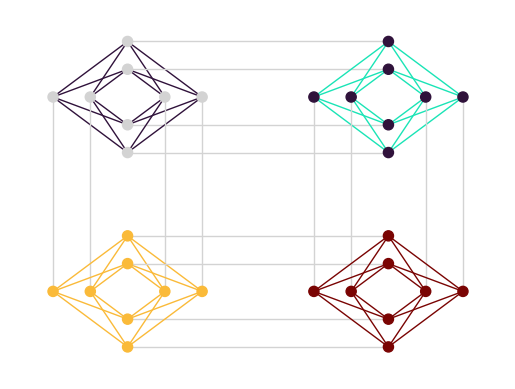

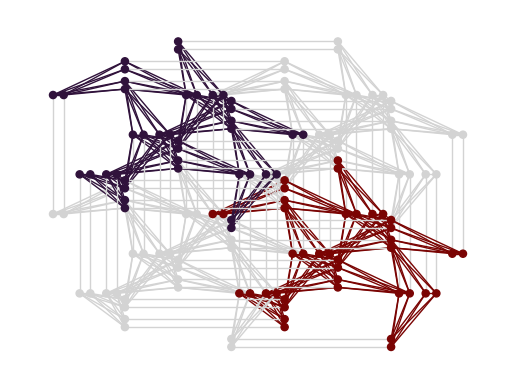

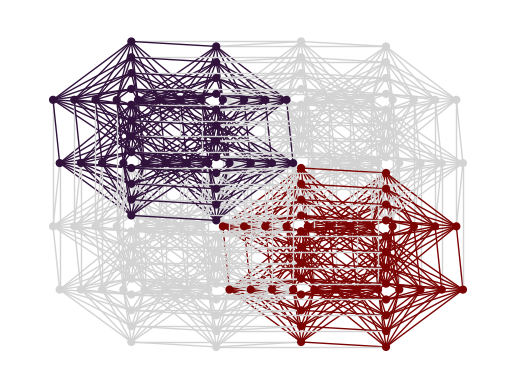

In [87]:
# Define the Graph Topologies, Tiles, and Generators
topologies = ['chimera', 'pegasus', 'zephyr']
smallest_tile = {'chimera': 1, 'pegasus': 2, 'zephyr': 1}
generators = {'chimera': dnx.chimera_graph, 'pegasus': dnx.pegasus_graph, 'zephyr': dnx.zephyr_graph}

# A check at minimal scale and visualization
for topology in topologies:
    min_raster_scale = smallest_tile[topology]
    S = generators[topology](min_raster_scale)
    T = generators[topology](min_raster_scale + 1)

    # Perform Embedding Search and Validation
    embs = raster_embedding_search(S, T, raster_breadth=min_raster_scale)
    assert all(set(emb.keys()) == set(S.nodes()) for emb in embs)
    assert all(set(emb.values()).issubset(set(T.nodes())) for emb in embs)
    value_list = [v for emb in embs for v in emb.values()]
    assert len(set(value_list)) == len(value_list)

    # Visualize Embeddings
    visualize_embeddings(H=T, embeddings=embs)


### Process stored JSON data

Processes experimental data stored in a JSON file for 20 runs. Measures embedding times across three topologies with various source graph (**1-D ring**) sizes. Evaluates results across different target graph tile sizes. Calculates the mean and standard error of the mean (SEM) for each combination of tile size, topology, and raster breadth.

In [90]:
# Load the JSON data from a file
with open('experiment_results/ring.json', 'r') as file:
    data = json.load(file)

# Initialize an empty list to store records
records = []

# Iterate over tile sizes (assuming 'L' corresponds to 'tile_size')
for tile_size in data:
    for topology in data[tile_size]:
        raster_breadth = data[tile_size][topology].get('Raster_Breadth', None)
        time_entries = data[tile_size][topology]['Time_1']
        for entry in time_entries:
            record = {
                'L': int(tile_size),
                'Topology': topology,
                'Raster_Breadth': raster_breadth,
                'Run': entry['Run'],
                'm_target': entry['m_target'],
                'Time_1': entry['Time_1'],
            }
            records.append(record)

# Convert the list of records into a DataFrame
df = pd.DataFrame(records)

# Filter for even Ls
df_even = df[df['L'] % 2 == 0]
# Replace 'null' strings with NaN
df_even['Time_1'] = df_even['Time_1'].replace('null', np.nan)

# Convert 'Time_1' to numeric, coercing errors to NaN
df_even['Time_1'] = pd.to_numeric(df_even['Time_1'], errors='coerce')

# Now fill NaN with 1
df_even['Time_1'] = df_even['Time_1'].fillna(1)

# Display the first few rows to verify
print(df_even.head())
print(df_even.dtypes)

df_aggregated = (
    df_even
    .groupby(['L', 'Topology', 'Raster_Breadth'], as_index=False)
    .agg(
        Time_1_mean=('Time_1', 'mean'),
        Time_1_sem=('Time_1', lambda x: np.std(x) / np.sqrt(len(x)))  # SEM
    )
)
print(df_aggregated.head())

    L Topology  Raster_Breadth  Run  m_target    Time_1
0  16  chimera             2.0    1         2  0.001491
1  16  chimera             2.0    2         2  0.001049
2  16  chimera             2.0    3         2  0.000984
3  16  chimera             2.0    4         2  0.001093
4  16  chimera             2.0    5         2  0.000992
L                   int64
Topology           object
Raster_Breadth    float64
Run                 int64
m_target            int64
Time_1            float64
dtype: object
    L Topology  Raster_Breadth  Time_1_mean  Time_1_sem
0  16  chimera             2.0     0.001111    0.000051
1  16  pegasus             2.0     0.001720    0.000034
2  16   zephyr             1.0     0.002496    0.000041
3  18  chimera             2.0     0.001062    0.000026
4  18  pegasus             2.0     0.001736    0.000021


/var/folders/mv/q4q30tz15gd36zkk1phksyrm0000gs/T/ipykernel_62057/3860730838.py:30: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_even['Time_1'] = df_even['Time_1'].replace('null', np.nan)
/var/folders/mv/q4q30tz15gd36zkk1phksyrm0000gs/T/ipykernel_62057/3860730838.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_even['Time_1'] = df_even['Time_1'].replace('null', np.nan)
/var/folders/mv/q4q30tz15gd36zkk1phksyrm0000gs/T/ipykernel_62057/3860730838.py:33: SettingWithCopyWarning: 
A value is trying to be set on a c

### Time to Find One Embedding for Smallest Viable Raster Breadth (Defect-Free Graph)
Visualizes the mean time data across different L values and topologies from the aggregated dataset, with shaded confidence intervals to represent variability. Marks an upper threshold line representing the specific timeout. The x- and y-axes are set to logarithmic scales for better readability across a wide data range.

#### **Purpose: examine how embedding time changes for specific loop length and title size**

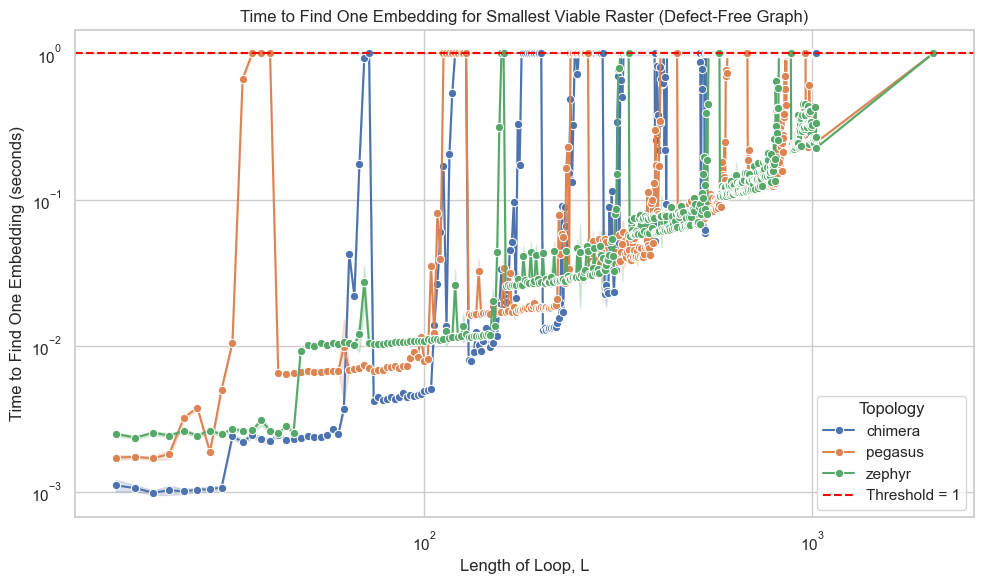

In [91]:
sns.set_theme(style="whitegrid")

# Plotting
plt.figure(figsize=(10, 6))
sns.lineplot(
    data=df_aggregated,
    x='L',
    y='Time_1_mean',
    hue='Topology',
    marker='o',
    errorbar=None 
)
# Define the confidence interval multiplier for 95% CI
ci_multiplier = 1.96

# Retrieve the unique topologies
topologies = df_aggregated['Topology'].unique()

# Retrieve the color palette used by Seaborn for consistency
palette = sns.color_palette(n_colors=len(topologies))
color_dict = dict(zip(topologies, palette))

# Iterate over each topology to plot confidence intervals
for topology in topologies:
    # Subset the data for the current topology and sort by 'L'
    subset = df_aggregated[df_aggregated['Topology'] == topology].sort_values('L')
    
    # Calculate the confidence interval bounds
    ci_lower = subset['Time_1_mean'] - ci_multiplier * subset['Time_1_sem']
    ci_upper = subset['Time_1_mean'] + ci_multiplier * subset['Time_1_sem']
    
    # Plot the shaded confidence interval
    plt.fill_between(
        subset['L'],
        ci_lower,
        ci_upper,
        color=color_dict[topology],
        alpha=0.2  # Transparency for the shaded region
    )

# Define the upper_threshold
upper_threshold = 1
plt.axhline(
    upper_threshold, 
    color='red', 
    linestyle='--', 
    label=f'Threshold = {upper_threshold}'
)

# Set logarithmic scales
plt.yscale('log')
plt.xscale('log')

# Set labels and title
plt.ylabel('Time to Find One Embedding (seconds)')
plt.xlabel('Length of Loop, L')
plt.title('Time to Find One Embedding for Smallest Viable Raster (Defect-Free Graph)')

# Configure the legend to include only Topology and Threshold
# To exclude the shaded regions from the legend, ensure that fill_between does not add labels
handles, labels = plt.gca().get_legend_handles_labels()
# Remove duplicate labels for Topology
from collections import OrderedDict
by_label = OrderedDict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), title='Topology')

# Adjust layout for better spacing
plt.tight_layout()

# Display the plot
plt.show()

#### **The distribution shows spikes pattern in execution time for certain tile sizes; aside from these spikes, execution times are generally consistent across topologies.**

### Topology Specific Visualizations with Tile Size Threshold Marked
The following plots visualize the time required to find a single embedding using the smallest viable raster breadth. Each plot is separated by topology, with vertical lines marking topology-specific tile sizes.

#### **Purpose: Investigate the relationship between topology-specific tile size and time spikes**

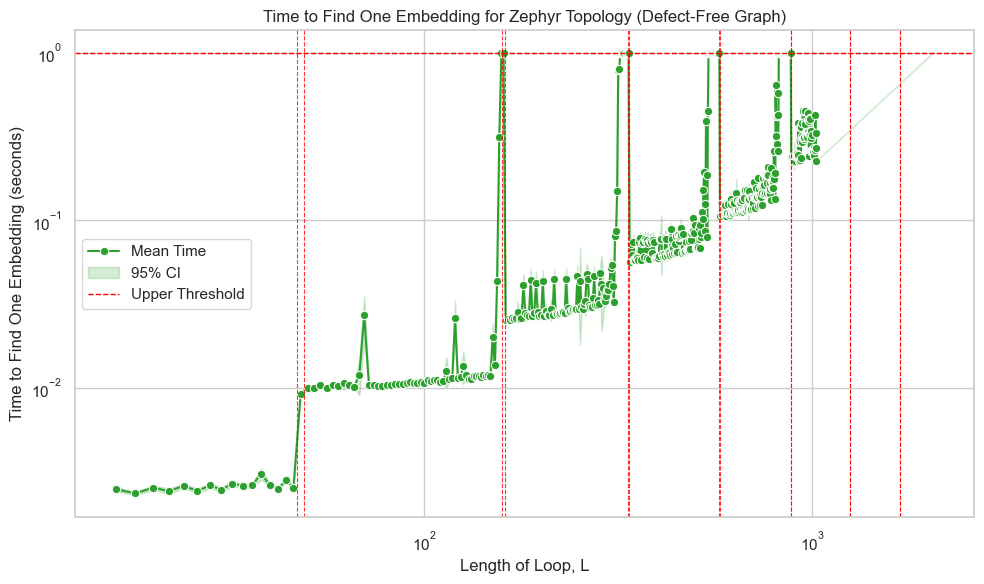

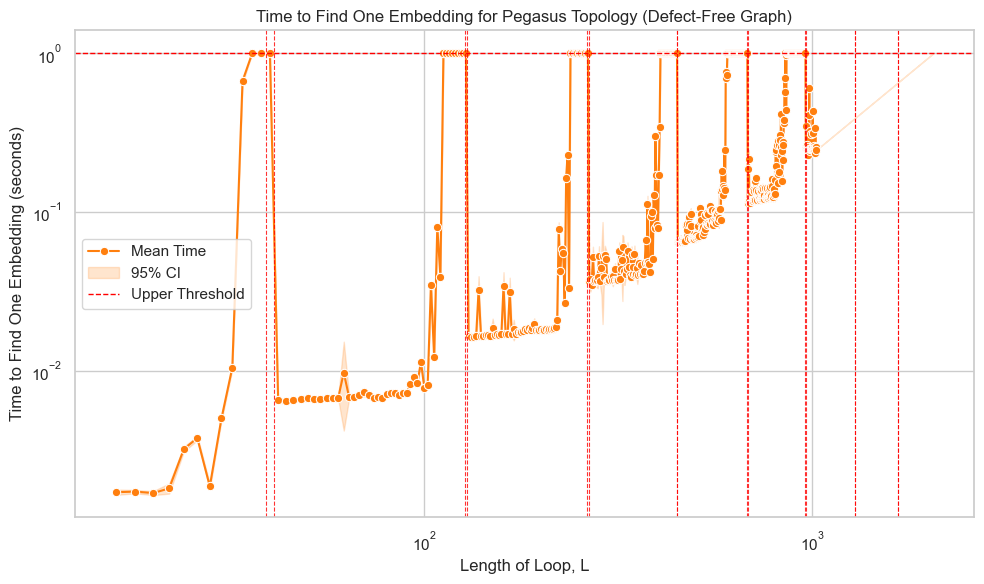

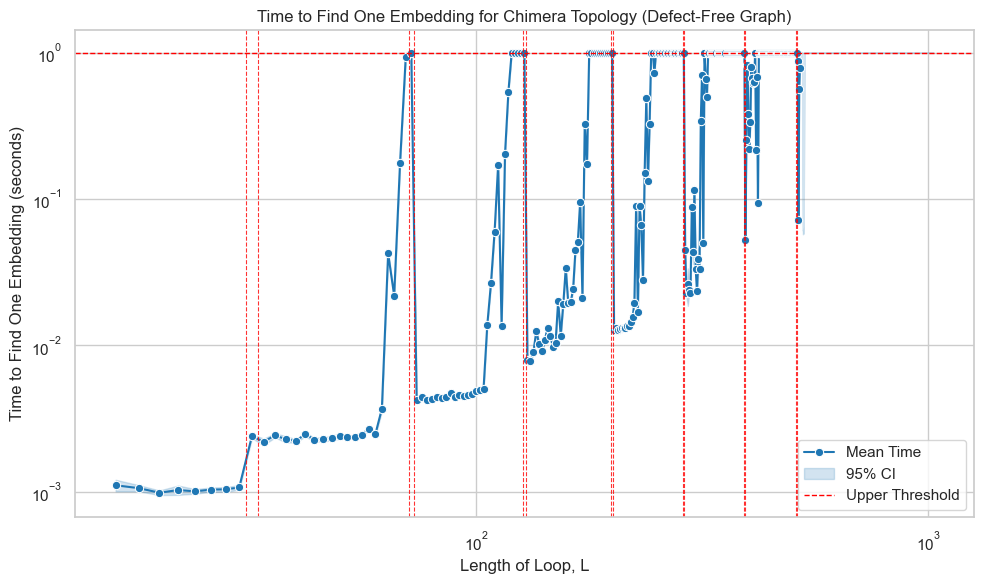

In [94]:
def plot_topology(df, topology, bounds, color, l_min, l_max, title):
    df_top = df[df['Topology'] == topology].copy()
    df_filtered = df_top[(df_top['L'] >= l_min) & (df_top['L'] <= l_max)].copy()
    ci_multiplier = 1.96
    plt.figure(figsize=(10, 6))
    
    # Plot the mean embedding time with markers
    sns.lineplot(
        data=df_filtered,
        x='L',
        y='Time_1_mean',
        color=color,
        marker='o',
        label='Mean Time'
    )
    
    # Calculate the confidence interval bounds
    ci_lower = df_top['Time_1_mean'] - ci_multiplier * df_top['Time_1_sem']
    ci_upper = df_top['Time_1_mean'] + ci_multiplier * df_top['Time_1_sem']
    
    # Plot the shaded confidence interval
    plt.fill_between(
        df_top['L'],
        ci_lower,
        ci_upper,
        color=color,
        alpha=0.2,
        label='95% CI'
    )
    
    # Add vertical lines at specified L sizes
    for L in bounds:
        plt.axvline(x=L, color='red', linestyle='--', linewidth=0.8, alpha=0.8)
    
    # Define the upper threshold line
    upper_threshold = 1
    plt.axhline(
        upper_threshold, 
        color='red', 
        linestyle='--',
        linewidth=1,
        label='Upper Threshold'
    )
    
    # Set logarithmic scales for both axes
    plt.yscale('log')
    plt.xscale('log')
    
    # Set labels and title
    plt.ylabel('Time to Find One Embedding (seconds)')
    plt.xlabel('Length of Loop, L')
    plt.title(title)
    
    plt.legend()
    plt.tight_layout()
    plt.show()

sns.set_theme(style="whitegrid")

# ------------------- Zephyr Topology Plot -------------------
zephyr_bounds = [47, 49, 159, 161, 335, 337, 575, 577, 879, 881, 1247, 1249, 1679, 1681]
zephyr_color = (0.17254901960784313, 0.6274509803921569, 0.17254901960784313)  # Greenish
zephyr_title = 'Time to Find One Embedding for Zephyr Topology (Defect-Free Graph)'

plot_topology(
    df=df_aggregated,
    topology='zephyr',
    bounds=zephyr_bounds,
    color=zephyr_color,
    l_min=16,
    l_max=1700,
    title=zephyr_title
)

# ------------------- Pegasus Topology Plot -------------------
pegasus_bounds = [39, 41, 127, 129, 263, 265, 447, 449, 679, 681, 959, 961, 1287, 1289, 1663, 1665]
pegasus_color = (1.0, 0.4980392156862745, 0.054901960784313725)  # Orange
pegasus_title = 'Time to Find One Embedding for Pegasus Topology (Defect-Free Graph)'

plot_topology(
    df=df_aggregated,
    topology='pegasus',
    bounds=pegasus_bounds,
    color=pegasus_color,
    l_min=16,
    l_max=1700,
    title=pegasus_title
)

# ------------------- Chimera Topology Plot -------------------
chimera_bounds = [31, 33, 71, 73, 127, 129, 199, 201, 287, 289, 391, 393, 511, 513]
chimera_color = (0.12156862745098039, 0.4666666666666667, 0.7058823529411765)  # Bluish
chimera_title = 'Time to Find One Embedding for Chimera Topology (Defect-Free Graph)'

plot_topology(
    df=df_aggregated,
    topology='chimera',
    bounds=chimera_bounds,
    color=chimera_color,
    l_min=16,
    l_max=520,
    title=chimera_title
)

#### **When the loop length is comparable to the graph size, the timescale significantly increases!**

### Ring example with minimum raster breadth + 1

/var/folders/mv/q4q30tz15gd36zkk1phksyrm0000gs/T/ipykernel_62057/3932819601.py:23: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['Time_1'] = df['Time_1'].replace('null', np.nan)


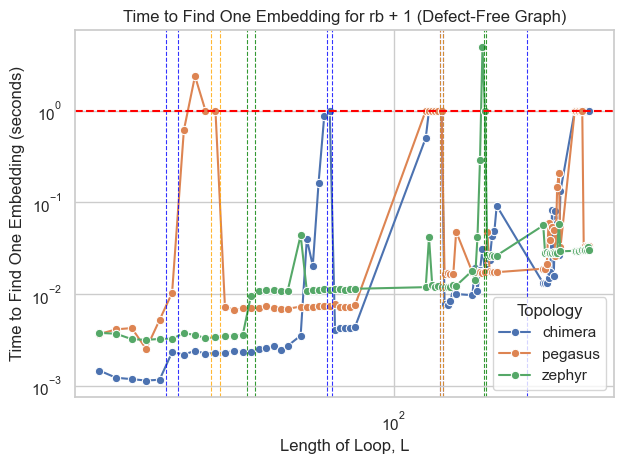

In [58]:
# Load the JSON data from a file
with open('experiment_results/ring(min+1).json', 'r') as file:
    data = json.load(file)

# Initialize an empty list to store records
records = []

# Iterate over tile sizes (assuming 'L' corresponds to 'tile_size')
for tile_size in data:
    for topology in data[tile_size]:
        time_entries = data[tile_size][topology]['Time_1']
        for entry in time_entries:
            record = {
                'L': int(tile_size),
                'Topology': topology,
                'm_target': entry['m_target'],
                'Time_1': entry['Time_1'],
            }
            records.append(record)

# Convert the list of records into a DataFrame
df = pd.DataFrame(records)
df['Time_1'] = df['Time_1'].replace('null', np.nan)
df['Time_1'] = pd.to_numeric(df['Time_1'], errors='coerce')
df['Time_1'] = df['Time_1'].fillna(1)

sns.set_theme(style="whitegrid")
sns.lineplot(
    data=df,
    x='L',
    y='Time_1',
    hue='Topology',
    marker='o',
)

chimera_bounds = [31, 33, 71, 73, 127, 129, 199]
for L in chimera_bounds:
    plt.axvline(x=L, color='blue', linestyle='--', linewidth=0.8, alpha=0.8)

pegasus_bounds = [39, 41, 127, 129]
for L in pegasus_bounds:
    plt.axvline(x=L, color='orange', linestyle='--', linewidth=0.8, alpha=0.8)

zephyr_bounds = [47, 49, 159, 161]
for L in zephyr_bounds:
    plt.axvline(x=L, color='green', linestyle='--', linewidth=0.8, alpha=0.8)

plt.axhline(1, color='red', linestyle='--')
plt.yscale('log')  
plt.xscale('log') 
plt.ylabel('Time to Find One Embedding (seconds)')
plt.xlabel('Length of Loop, L')
plt.title('Time to Find One Embedding for rb + 1 (Defect-Free Graph)')
plt.legend(title='Topology')
plt.tight_layout()
plt.show()


### Full-scale visualization (L=256, infinite max embeddings, defect free case)

In [64]:
folder_path = "experiment_results"
file_name = f"fullscale_pegasus(defect_free).json"
file_path = os.path.join(folder_path, file_name)
experiment_results = {}
L = 256
# Create a 1D chain (path graph) of length L
S = nx.from_edgelist({(i, (i+1)%L) for i in range(L)}) 
target_topology = 'pegasus'
L_str = str(L)
generator = {'chimera': dnx.chimera_graph, 'pegasus': dnx.pegasus_graph, 'zephyr': dnx.zephyr_graph}
max_processor_scale = {'chimera': 16, 'pegasus': 16, 'zephyr': 12}
timeout = 1 
# Initialize the data structure for the new (L, Topology) pair
experiment_results.setdefault(L_str, {}).setdefault(target_topology, {})

# Compute the minimal raster breadth required for embedding S into the target topology
rb = raster_breadth_subgraph_lower_bound(S, topology=target_topology)

experiment_results[L_str][target_topology]['Time_1'] = []
# Try increasing m_target to find embeddings (up to max_processor_scale)
for m_target in [max_processor_scale[target_topology]]:

        # Generate target topology graph T
        T = generator[target_topology](m_target)
        
        # Time to first valid embedding
        t0 = perf_counter()
        embs = raster_embedding_search(S, T, raster_breadth=rb,
                                    max_num_emb=1, timeout=timeout)
        
        # Check if embedding was found
        if len(embs) < 1:
            # No embedding found, record as "null"
            experiment_results[L_str][target_topology]['Time_1'].append({
                'm_target': m_target,
                'Time_1': "null"
            })
        else:
            experiment_results[L_str][target_topology]['Time_1'].append({
                'm_target': m_target,
                'Time_1': perf_counter() - t0
            })
            # break  # Found an embedding; proceed to next L

# Save the results to a JSON file
with open(file_path, 'w') as json_file:
    json.dump(experiment_results, json_file, indent=4)

KeyboardInterrupt: 